## Echo state network (ESN) torch version from [pyESN](https://github.com/cknd/pyESN)

### ESN structure

In [1]:
import torch
import torch.nn as nn
import numpy as np

class ESN(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=torch.tanh, inverse_out_activation=torch.tanh,
                 random_state=None, silent=True):
        super(ESN, self).__init__()
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = self.correct_dimensions(input_shift, n_inputs)
        self.input_scaling = self.correct_dimensions(input_scaling, n_inputs)
        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift
        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        self.teacher_forcing = teacher_forcing
        self.silent = silent

        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            self.random_state_ = np.random.RandomState(random_state)
        else:
            self.random_state_ = np.random.mtrand._rand

        self.initweights()

    def correct_dimensions(self, param, n):
        if param is None:
            return None
        if np.isscalar(param):
            return np.full(n, param)
        return np.array(param)

    def initweights(self):
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = torch.tensor(W * (self.spectral_radius / radius), dtype=torch.float32)

        self.W_in = torch.tensor(self.random_state_.rand(self.n_reservoir, self.n_inputs) * 2 - 1, dtype=torch.float32)
        self.W_feedb = torch.tensor(self.random_state_.rand(self.n_reservoir, self.n_outputs) * 2 - 1, dtype=torch.float32)

    def _update(self, state, input_pattern, output_pattern):
        if self.teacher_forcing:
            preactivation = (torch.matmul(self.W, state)
                             + torch.matmul(self.W_in, input_pattern)
                             + torch.matmul(self.W_feedb, output_pattern))
        else:
            preactivation = (torch.matmul(self.W, state)
                             + torch.matmul(self.W_in, input_pattern))
        return torch.tanh(preactivation) + self.noise * (torch.rand(self.n_reservoir) - 0.5)

    def _scale_inputs(self, inputs):
        if self.input_scaling is not None:
            inputs = inputs * torch.tensor(self.input_scaling, dtype=torch.float32)
        if self.input_shift is not None:
            inputs = inputs + torch.tensor(self.input_shift, dtype=torch.float32)
        return inputs

    def _scale_teacher(self, teacher):
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.float32)

        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")

        states = torch.zeros((inputs.shape[0], self.n_reservoir), dtype=torch.float32)
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :], teachers_scaled[n - 1, :])

        if not self.silent:
            print("fitting...")

        transient = min(int(inputs.shape[1] / 10), 100)
        extended_states = torch.cat((states, inputs_scaled), dim=1)
        self.W_out = torch.matmul(torch.pinverse(extended_states[transient:, :]),
                                  self.inverse_out_activation(teachers_scaled[transient:, :])).T

        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        if inspect:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto', interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        pred_train = self._unscale_teacher(self.out_activation(
            torch.matmul(extended_states, self.W_out.T)))
        if not self.silent:
            print(torch.sqrt(torch.mean((pred_train - outputs) ** 2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        inputs = torch.tensor(inputs, dtype=torch.float32)
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = torch.zeros(self.n_reservoir, dtype=torch.float32)
            lastinput = torch.zeros(self.n_inputs, dtype=torch.float32)
            lastoutput = torch.zeros(self.n_outputs, dtype=torch.float32)

        inputs = torch.cat([lastinput.unsqueeze(0), self._scale_inputs(inputs)], dim=0)
        states = torch.cat([laststate.unsqueeze(0), torch.zeros((n_samples, self.n_reservoir), dtype=torch.float32)], dim=0)
        outputs = torch.cat([lastoutput.unsqueeze(0), torch.zeros((n_samples, self.n_outputs), dtype=torch.float32)], dim=0)

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(torch.matmul(self.W_out,
                                                                 torch.cat([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

### ESN on Lorenz-63 (Dimension=3)

In [2]:
# data preparation
import scipy.io as sio
lorenz_path = 'Your path to the Lorenz data'
sub = 6
lorenz_data = sio.loadmat(lorenz_path)['u'][::sub]
ntrain = 160000
ntest = 38000
train_data = lorenz_data[:ntrain]
train_truth = lorenz_data[1:ntrain+1]
test_data = lorenz_data[ntrain:ntrain+ntest-1]
test_truth = lorenz_data[ntrain+1:ntrain+ntest]


In [3]:
esn = ESN(n_inputs=3, n_outputs=3, n_reservoir=200, spectral_radius=0.9, sparsity=0.1, noise=0.01)
esn.fit(train_data, train_truth)
prediction = esn.predict(test_data)
print("test error: \n"+str(torch.sqrt(torch.mean((prediction.flatten() - test_truth.flatten())**2))))

test error: 
tensor(15.7380, dtype=torch.float64)


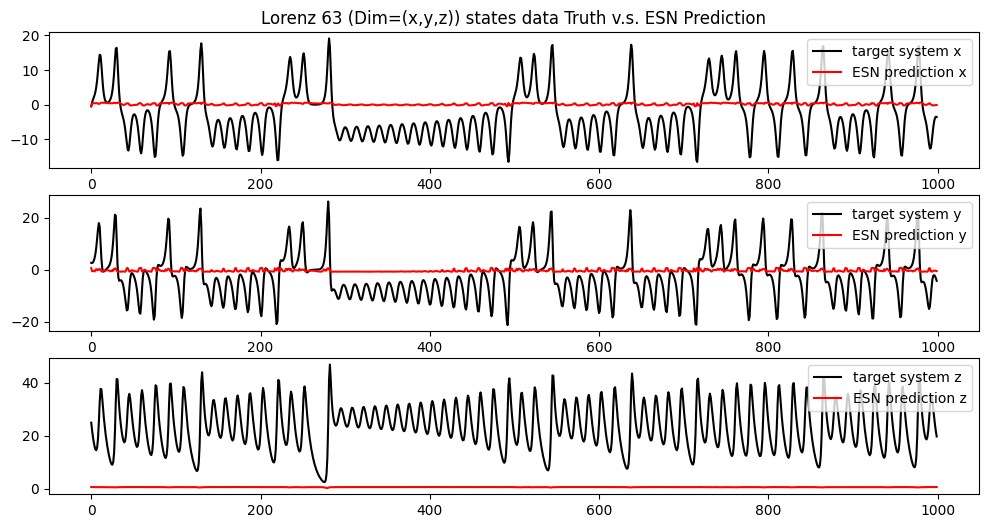

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 6))
plot_len = 1000
axs[0].set_title("Lorenz 63 (Dim=(x,y,z)) states data Truth v.s. ESN Prediction")

for i in range(3):
      axs[i].plot(range(0, plot_len), test_truth[:plot_len, i], 'k', label=f"target system {['x', 'y', 'z'][i]}", )
      axs[i].plot(range(0, plot_len), prediction[:plot_len, i], 'r', label=f"ESN prediction {['x', 'y', 'z'][i]}")
      axs[i].legend(loc='upper right')


### ESN on KS equation (Dimension = 128)

In [5]:
# Main
n_train = 900
n_test = 100

sub = 4 # spatial subsample
S = 512
s = S//sub

T_in = 10 
T = 1600 # seconds to extract from each trajectory in data
T_out = T_in + T

In [6]:
# Load data
import h5py
KS_path = 'Your path to the KS data'
with h5py.File(KS_path, 'r') as f:
      KS_data = f['u'][::sub]
data_tensor = torch.tensor(KS_data, dtype=torch.float)[...,::sub]

# randomly sample half episodes from the train data episodes
episode_samples = int(0.5*n_train)
data_sampled_train = data_tensor[torch.randperm(data_tensor[:n_train].size(0))[:episode_samples],:,:]
data_sampled_test = data_tensor[torch.randperm(data_tensor[-n_test:].size(0)),:,:]

In [7]:
trainlen, test_len = 20000, 10000
train_a = data_sampled_train[:,T_in-1:T_out-1,:].reshape(-1, s)
train_u = data_sampled_train[:,T_in:T_out,:].reshape(-1, s)
test_a = data_sampled_test[:,T_in-1:T_out-1,:].reshape(-1, s)
test_u = data_sampled_test[:,T_in:T_out,:].reshape(-1, s)

In [8]:
esn = ESN(n_inputs=128, n_outputs=128, n_reservoir=4000, spectral_radius=0.9, sparsity=0.1, noise=0.01)
esn.fit(train_a[:trainlen], train_u[:trainlen])
prediction = esn.predict(test_a[:test_len])

/var/folders/r1/v7355v5n0y3cw6l975b_dspm0000gn/T/ipykernel_63872/2604320892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/r1/v7355v5n0y3cw6l975b_dspm0000gn/T/ipykernel_63872/2604320892.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.float32)
/var/folders/r1/v7355v5n0y3cw6l975b_dspm0000gn/T/ipykernel_63872/2604320892.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


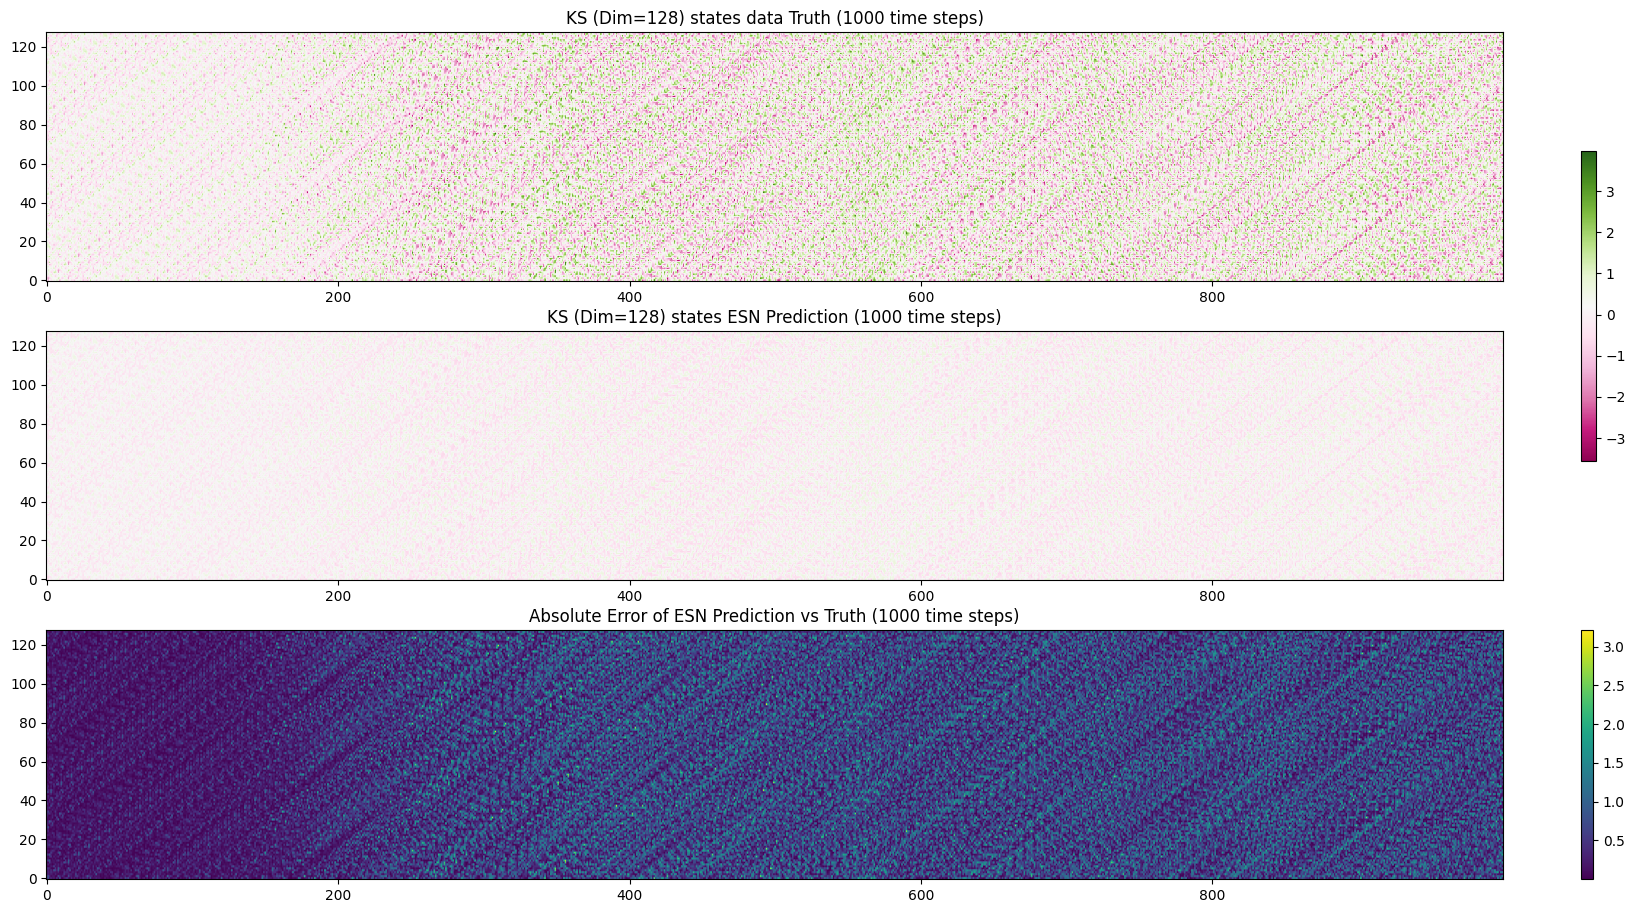

In [9]:
fig,ksax = plt.subplots(3,1,figsize=(20,11))
vmin, vmax = torch.min(test_u[:test_len//10]), torch.max(test_u[:test_len//10])
ksax[0].set_title('KS (Dim=128) states data Truth (1000 time steps)')
im1 = ksax[0].imshow(test_u[:test_len//10].T, aspect='auto', cmap='PiYG', vmin=vmin, vmax=vmax, origin='lower')
ksax[1].set_title('KS (Dim=128) states ESN Prediction (1000 time steps)')
ksax[1].imshow(prediction[:test_len//10].T, aspect='auto', cmap='PiYG', vmin=vmin, vmax=vmax, origin='lower')
colorbar1 = fig.colorbar(im1, ax=[ksax[0], ksax[1]], orientation='vertical', fraction=0.01)
ksax[2].set_title('Absolute Error of ESN Prediction vs Truth (1000 time steps)')
im2 = ksax[2].imshow(abs(prediction[:test_len//10]-test_u[:test_len//10]).T, aspect='auto', cmap='viridis', origin='lower')
colorbar2 = fig.colorbar(im2, ax=ksax[2], orientation='vertical', fraction=0.01)